# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Первичный осмотр

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

In [3]:
print(data.head(60))

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20  13000000.0      108.00  2019-03-07T00:00:00      3   
1              7   3350000.0       40.40  2018-12-04T00:00:00      1   
2             10   5196000.0       56.00  2015-08-20T00:00:00      2   
3              0  64900000.0      159.00  2015-07-24T00:00:00      3   
4              2  10000000.0      100.00  2018-06-19T00:00:00      2   
5             10   2890000.0       30.40  2018-09-10T00:00:00      1   
6              6   3700000.0       37.30  2017-11-02T00:00:00      1   
7              5   7915000.0       71.60  2019-04-18T00:00:00      2   
8             20   2900000.0       33.16  2018-05-23T00:00:00      1   
9             18   5400000.0       61.00  2017-02-26T00:00:00      3   
10             5   5050000.0       39.60  2017-11-16T00:00:00      1   
11             9   3300000.0       44.00  2018-08-27T00:00:00      2   
12            10   3890000.0       54.00  2016-06-30T00:00:00   

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

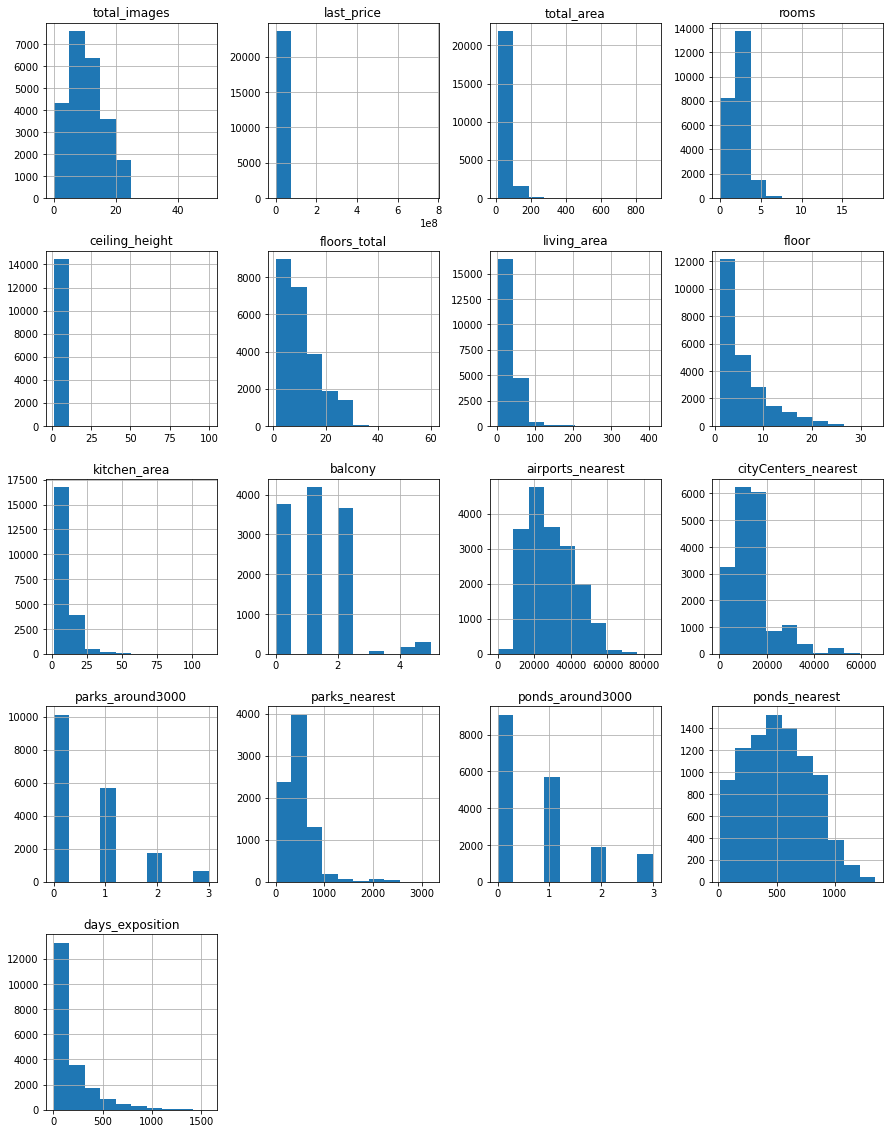

In [5]:
data.hist(figsize=(15,20))

## Предобработка данных

Поиск пропущенных значений

In [6]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Заполнение пропусков

Пропуски в столбцах с высотой потолков и количеством этажей в доме я решил заполнить медианным значением
Скорей всего эти пропуски вызваны тем, что их просто не указали в анкете на сайте объявлений

In [7]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

Пропуски в столбце с жилплощадью я заполню медианной жилплощадью квартитр с таким же количестовом комнат

In [8]:
for t in data['rooms'].unique():
    data.loc[(data['rooms'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == t), 'living_area'].median()

Далее, я взялся за столбец is_apartment, который должен отвечать на вопрос о том, является ли данная квартира - апартаментами?
Но в этом столбце есть проблемма - пропусков слишком много

In [9]:
#пытаюсь разобраться со столбцом is_apartment
print(data.groupby('is_apartment')['is_apartment'].count())
print(data['is_apartment'].isna().sum())
#Видимо, пропуски означают то, что квартиры не являються апартаментами
data['is_apartment'] = data['is_apartment'].fillna(False)

is_apartment
False    2725
True       50
Name: is_apartment, dtype: int64
20924


Пропуски в столбце с площадью кухни я заполню медианным значением 

In [10]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

In [11]:
#пропуски в стобце balcony скорей всего были вызваны отсутсвием балкона
data['balcony'] = data['balcony'].fillna(0.0)

Пропуски в столбце с названием населённого пункта я заменю словом 'неизвестно'

In [12]:
data['locality_name'] = data['locality_name'].fillna('неизвестно')

Следующими по очереди идут 7 столбцов с пропусками которые я разделил на две группы:

1)Столбцы, количество пропусков в которых не превышает 5500 или 25% от общего, которые я хочу заменить медианными значениями
Там я обратил внимание на то, что такие пропуски часто встречаются в маленьких населённых пунктах, отчего напрашиваеться вывод что скорей всего в этом насёлённом пункте вообще нету центра города/аэропорта/парка/пруда

2)Столбцы, количество пропусков в которых превышает 14000.
Я бы хотел обратить внимание на вторую группу:
эти два столбца отвечают за расстояние до близжайшего парка/пруда, и при изучении таблицы, я заметил, что у этих столбцов есть очевидная корреляция со столбцами с количеством парков/прудов в радиусе 3км.
И если значение в столбце с количестов прудов/парков в радиусе равно нулю, то в столбце с расстоянием обязательно будет пропуск. Отсюда идёт вывод - если расстояние до близжайшего парка/пруда неизвестно, то это значит что он находиться слишком далеко

Поэтому я сделал вывод о том, что пропуски там вполне уместны

## Изменение типов данных

Характер данных, указанных в столбце first_day_exposition явно указывает на то, что в нём должны находиться дата и время и он должен принадлежать к типу datetime

In [13]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
print(data.head(20))

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20  13000000.0      108.00           2019-03-07      3   
1              7   3350000.0       40.40           2018-12-04      1   
2             10   5196000.0       56.00           2015-08-20      2   
3              0  64900000.0      159.00           2015-07-24      3   
4              2  10000000.0      100.00           2018-06-19      2   
5             10   2890000.0       30.40           2018-09-10      1   
6              6   3700000.0       37.30           2017-11-02      1   
7              5   7915000.0       71.60           2019-04-18      2   
8             20   2900000.0       33.16           2018-05-23      1   
9             18   5400000.0       61.00           2017-02-26      3   
10             5   5050000.0       39.60           2017-11-16      1   
11             9   3300000.0       44.00           2018-08-27      2   
12            10   3890000.0       54.00           2016-06-30   

Столбец floors_total указывает на количество этажей в доме, количество которых может быть только целым числом,
но данный столбец имеет тип float64, что я и хочу исправить 

In [14]:
data['floors_total']=data['floors_total'].astype('int64')

В столбце is_apartment может быть только два возможных значения : Да и Нет
Поэтому я изменю его тип на логический

In [15]:
data['is_apartment']=data['is_apartment'].astype('bool')

Количество балконов может быть только целым числом

In [16]:
data['balcony']=data['balcony'].astype('int64')

В последнем столбце days_exposition, указаны только целые числа, да и количество дней должно быть целым
Но там есть проблема в виде пропусков, которые не дают изменить тип столбца,
Поэтому я сначала заполню их медианным значением

In [17]:
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())
data['days_exposition'] = data['days_exposition'].astype('int64')

Проверка результатов обработки пропусков и изменения типов данных

In [18]:
data.info()
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Результаты соответсвуют ожиданиям

## Обработка аномалий и неявных дупликатов

Поиск неявных дупликатов

In [19]:
#получение списка уникальных значений
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Замеченные проблемы:
1)большие и маленькие буквы
2)Путаница с буквами "е" и "ё"
3)Тип населённого пункта перед его названием(Посёлок, деревня, ПГТ, и так далее)

In [20]:
#решение первой проблемы
data['locality_name'] = data['locality_name'].str.lower()
#решение второй проблемы
data['locality_name'] = data['locality_name'].str.replace('ё','е')

Для того, чтобы решить третью проблему я решил вырезать все слова, которые указывают на тип насёлённого пункта. Но для того чтобы найти эти слова, мне нужно получить список названий населённых пунктов, отсортированный по алфавиту

In [21]:
locality_list=data['locality_name'].sort_values().unique()
print(locality_list)

['бокситогорск' 'волосово' 'волхов' 'всеволожск' 'выборг' 'высоцк'
 'гатчина' 'городской поселок большая ижора' 'городской поселок будогощь'
 'городской поселок виллози' 'городской поселок лесогорский'
 'городской поселок мга' 'городской поселок назия'
 'городской поселок новоселье' 'городской поселок павлово'
 'городской поселок рощино' 'городской поселок свирьстрой'
 'городской поселок советский' 'городской поселок федоровское'
 'городской поселок янино-1' 'деревня агалатово' 'деревня аро'
 'деревня батово' 'деревня бегуницы' 'деревня белогорка'
 'деревня большая вруда' 'деревня большая пустомержа'
 'деревня большие колпаны' 'деревня большое рейзино'
 'деревня большой сабск' 'деревня бор' 'деревня борисова грива'
 'деревня ваганово' 'деревня вартемяги' 'деревня вахнова кара'
 'деревня выскатка' 'деревня гарболово' 'деревня глинка'
 'деревня горбунки' 'деревня гостилицы' 'деревня заклинье'
 'деревня заневка' 'деревня зимитицы' 'деревня извара' 'деревня иссад'
 'деревня калитино' 'дере

In [22]:
#решение третьей проблемы
def cleaning_name_type(column):
    clean_names_column = column.str.replace("|".join(["поселок",
                                                    "деревня",
                                                    "городского",
                                                    "типа","городской","коттеджный","садоводческое","некоммерческое","товарищество","село"]), "", regex=True).str.strip()
    return clean_names_column

data.insert(loc=15, column='locality_clean_name', value=cleaning_name_type(data['locality_name']))

In [23]:
#проверка результата
print(data['locality_clean_name'].unique())
print(data['locality_clean_name'].unique())

['санкт-петербург' 'шушары' 'янино-1' 'парголово' 'мурино' 'ломоносов'
 'сертолово' 'петергоф' 'пушкин' 'кудрово' 'коммунар' 'колпино'
 'красный бор' 'гатчина' 'федоровское' 'выборг' 'кронштадт' 'кировск'
 'новое девяткино' 'металлострой' 'лебяжье' 'сиверский' 'молодцово'
 'кузьмоловский' 'садовое  новая ропша' 'павловск' 'пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк' 'куттузи'
 'аннино' 'ефимовский' 'плодовое' 'заклинье' 'торковичи' 'первомайское'
 'красное' 'понтонный' 'сясьстрой' 'старая' 'лесколово' 'новый свет'
 'сланцы' 'путилово' 'ивангород' 'шлиссельбург' 'никольское' 'зеленогорск'
 'сосновый бор' 'оржицы' 'кальтино' 'романовка' 'бугры' 'рощино' 'кириши'
 'луга' 'волосово' 'отрадное' 'павлово' 'оредеж' 'копорье' 'молодежное'
 'тихвин' 'победа' 'нурма' 'синявино' 'тосно' 'стрельна' 'бокситогорск'
 'александровская' 'лопухинка' 'пикалево' 'терволово' 'советский'
 'подпорожье' 'петровское' 'токсово' 'сельцо' 'вырица' 'кипень' 'келози'
 'вартемяги' 'тельман

**Поиск выбросов**

In [24]:
#проверка last_price
data['last_price'].describe()
#всё в порядке
#print(data['last_price'].sort_values().tail(20))
#cамые крупные значения тоже выглядят уместно

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [25]:
#проверка total_area
data['total_area'].describe()
#максимальное значение выглядит подозрительно
print(data['total_area'].sort_values().tail(20))
#На фоне остальных крупнейших значений оно выглядит нормально

14991    413.50
22131    422.20
21955    431.00
3676     441.98
20273    460.80
6221     470.30
660      483.90
6621     488.00
22494    491.00
9826     494.10
12401    495.00
15016    500.00
5893     500.00
8018     507.00
4237     517.00
5358     590.00
15651    618.00
3117     631.00
12859    631.20
19540    900.00
Name: total_area, dtype: float64


In [26]:
#проверка rooms
data['rooms'].describe()
#минимальное значение выглядит неадекватно
print(data['rooms'].sort_values().head(20))
#обнаружены неуместные нулевые значения, изучаю проблемные строки
print(data.loc[data['rooms'].isna()])
#квартиры с нулевым количеством комнат достаточно мальенькие, скорей всего они однокомнатные
data['rooms'] = data['rooms'].replace(0,1)

9412     0
8886     0
18132    0
20002    0
21425    0
12229    0
3019     0
2532     0
22047    0
2727     0
20648    0
1625     0
22416    0
7008     0
15756    0
7003     0
23637    0
2719     0
19877    0
9511     0
Name: rooms, dtype: int64
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, locality_clean_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 23 columns]


In [27]:
#проверка ceiling_height
data['ceiling_height'].describe()
#минимальное и максимальное значение выглядит подозрительно
print(data['ceiling_height'].sort_values().head(20))
print(data['ceiling_height'].sort_values().tail(20))
#потолоки редко бывают выше 10м, видимо там ошиблись точкой
#нормы строительства говорят, что минимальная высота потолка равна 2.65м, я буду использовать это в функции
def ceiling_fix(ceiling):
    if ceiling > 20:
        return ceiling * 0.1
    elif ceiling < 2.65:
        return data['ceiling_height'].median()
    else:
        return ceiling
data['ceiling_height'] = data['ceiling_height'].apply(ceiling_fix)

22590    1.00
5712     1.20
16934    1.75
20520    2.00
552      2.00
4212     2.00
5850     2.00
16884    2.00
19098    2.00
16446    2.00
11352    2.00
2572     2.00
22960    2.00
19329    2.00
12755    2.20
17794    2.25
17762    2.30
5498     2.30
23498    2.30
1582     2.30
Name: ceiling_height, dtype: float64
355       25.0
18545     25.0
14382     25.0
4643      25.0
9379      25.0
6246      25.0
11285     25.0
5669      26.0
17857     27.0
21824     27.0
10773     27.0
4876      27.0
5807      27.0
5246      27.0
22938     27.0
20478     27.0
21377     27.5
3148      32.0
22336     32.0
22869    100.0
Name: ceiling_height, dtype: float64


In [28]:
#проверка floors_total
data['floors_total'].describe()
#всё в порядке

count    23699.000000
mean        10.667750
std          6.585961
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [29]:
#проверка living_area
data['living_area'].describe()
#минимальное и максимальное значение выглядит подозрительно
print(data['living_area'].sort_values().head(20))
print(data['living_area'].sort_values().tail(20))
#всё в порядке
#остальные столбцы выглядят адекватно

13915    2.0
21758    2.0
3242     3.0
23574    3.0
17582    5.0
21943    5.4
16431    6.0
19251    6.5
23208    8.0
20994    8.0
114      8.3
2309     8.4
21505    8.5
17248    8.9
19620    9.0
1326     9.0
7312     9.0
8325     9.0
680      9.0
22252    9.0
Name: living_area, dtype: float64
6221     248.7
12971    250.0
15701    250.0
1494     250.0
15151    250.0
793      250.0
1085     255.7
15651    258.0
19865    260.0
14498    264.5
22494    274.0
20273    279.6
14088    300.0
8018     301.5
660      312.5
12859    322.3
4237     332.0
12401    347.5
5358     409.0
19540    409.7
Name: living_area, dtype: float64


## Добавление новых столбцов

In [30]:
import datetime as dt
#создание дополнительных столбцов
data['price_per_square'] = data['last_price']/data['total_area']
data['publication_day'] = data['first_day_exposition'].dt.dayofweek
data['publication_month'] = data['first_day_exposition'].dt.strftime("%m")
data['publication_year'] = data['first_day_exposition'].dt.strftime("%Y")
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000

In [31]:
#Определение типа этажа
def floor_type(floor, floors_total):
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(lambda x: floor_type(x.floor, x.floors_total), axis=1)

## Исследовательский анализ данных

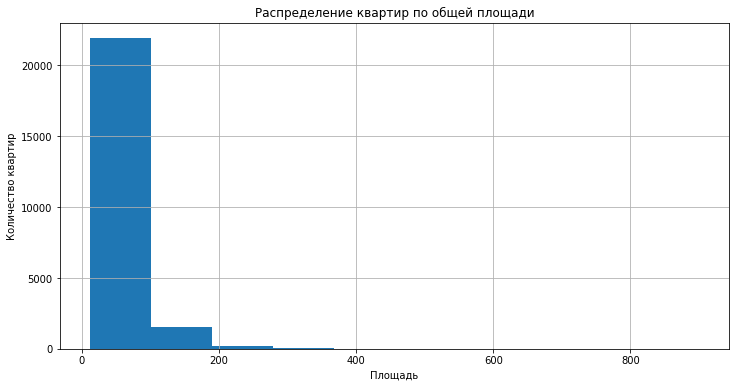

In [32]:
#исследую столбец total_area
data['total_area'].hist(figsize =(12,6))
plt.title('Распределение квартир по общей площади')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца total_area указывает на то, что площадь большинства квартир не превышает 100 кв.м

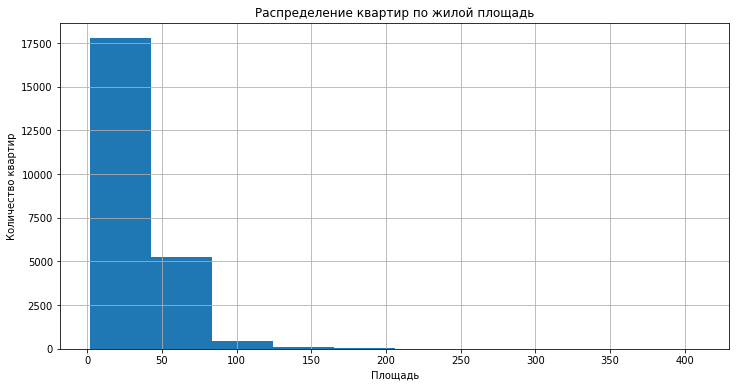

In [33]:
#исследую столбец living_area
data['living_area'].hist(figsize =(12,6))
plt.title('Распределение квартир по жилой площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца living_area говорит о том, что большинство квартир имеют жилплощадь меньше 50 кв.м
Также есть доля квартир с жилплощадью больше 50 кв.м и ниже 100 кв.м

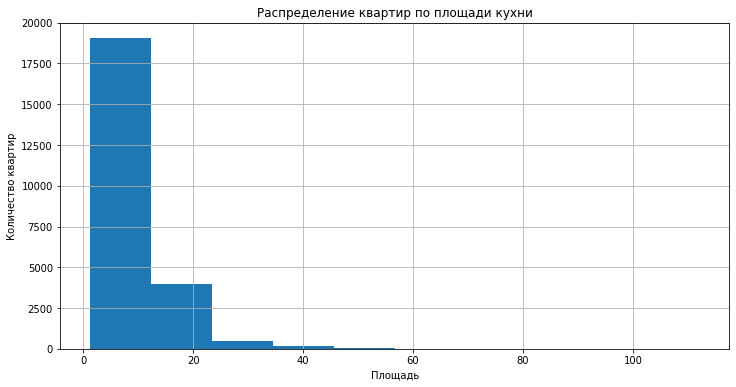

In [34]:
#исследую столбец kitchen_area
data['kitchen_area'].hist(figsize=(12,6))
plt.title('Распределение квартир по площади кухни')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца kitchen_area говорит о том, что большинство квартир имеют кухню с площадью меньше 20 кв.м

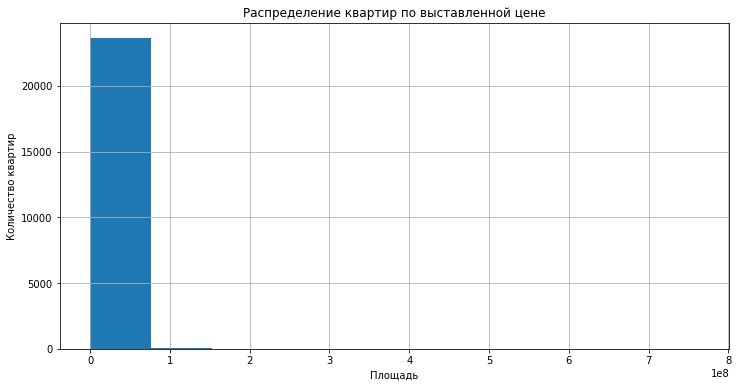

In [35]:
#исследую столбец last_price
data['last_price'].hist(figsize=(12,6))
plt.title('Распределение квартир по выставленной цене')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца last_price говорит о том, что большинство квартир было продано за цену ниже 10 млн

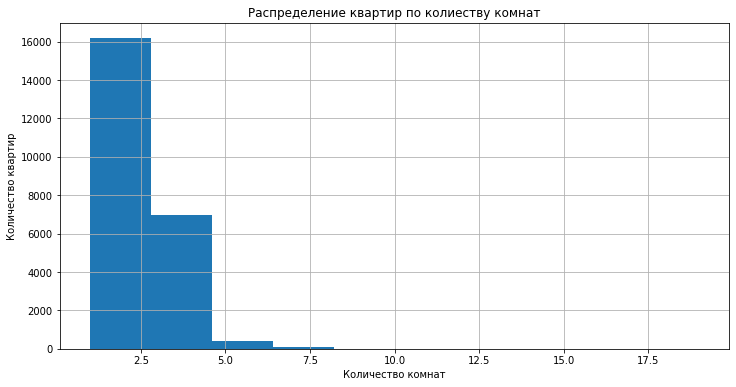

In [36]:
#исследую столбец rooms
data['rooms'].hist(figsize=(12,6))
plt.title('Распределение квартир по колиеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца rooms говорит о том, что большинство квартир являються однокомнатными, при этом есть значительная доля квартир с числом комнат от 2 до 4

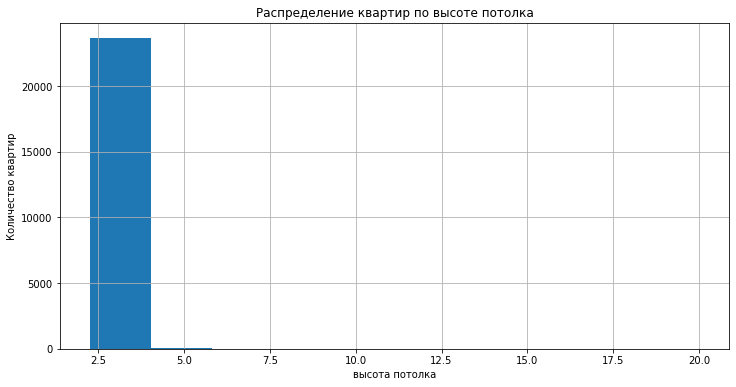

In [37]:
#исследую столбец ceiling_height
data['ceiling_height'].hist(figsize=(12,6))
plt.title('Распределение квартир по высоте потолка')
plt.xlabel('высота потолка')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца ceiling_height говорит о том, что большинство квартир имеют потолок, ниже 5м

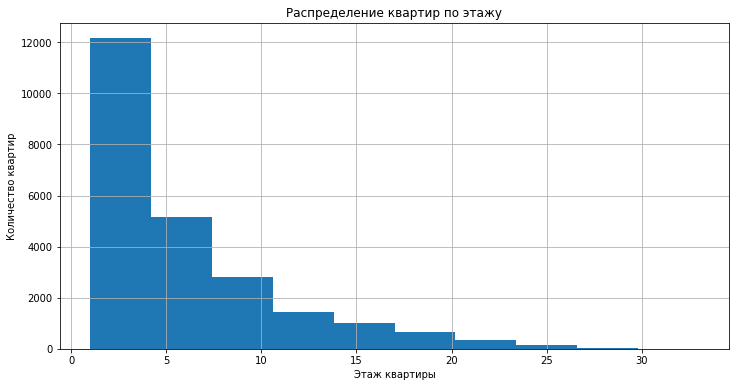

In [38]:
#исследую столбец floor
data['floor'].hist(figsize=(12,6))
plt.title('Распределение квартир по этажу')
plt.xlabel('Этаж квартиры')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца floor говорит о том, что разброс в этом столбце сильнее чем в предыдущих, но большинство квартир находяться на первых пяти этажах

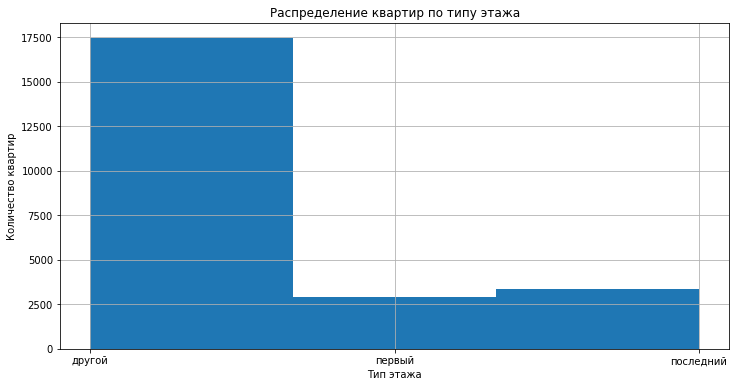

In [39]:
#исследую столбец floor_type
data['floor_type'].hist(figsize=(12,6), bins = 3)
plt.title('Распределение квартир по типу этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца floor_type говорит о том, что большинство квартир находится между первым и последним этажом, а квартиры на последнем этаже продают чаще, чем квартиры на первом

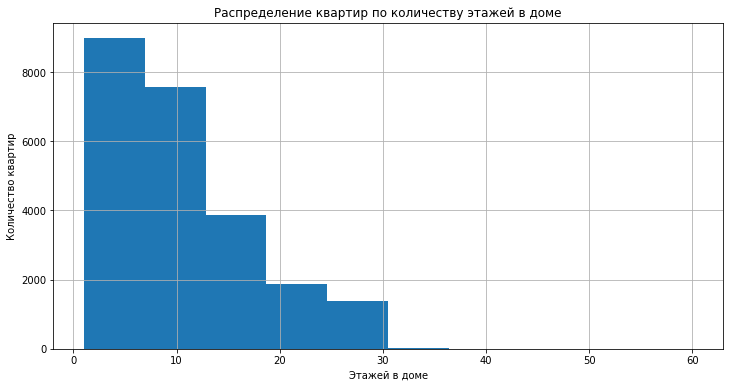

In [40]:
#исследую столбец floors_total
data['floors_total'].hist(figsize=(12,6))
plt.title('Распределение квартир по количеству этажей в доме')
plt.xlabel('Этажей в доме')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца floor_type говорит о том, что почти все квартиры в таблице не находятся в домах, с числом этажей больше тридцати, а большинство квартир на продаже находяться в домах с чилом этажей не больше десяти

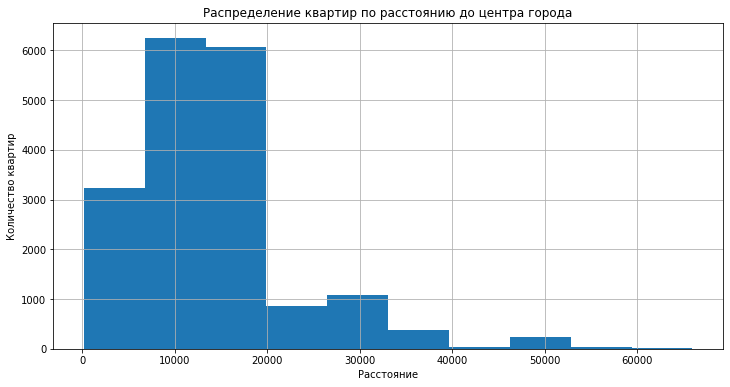

In [41]:
#исследую столбец cityCenters_nearest
data['cityCenters_nearest'].hist(figsize=(12,6))
plt.title('Распределение квартир по расстоянию до центра города')
plt.xlabel('Расстояние')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца cityCenters_nearest говорит о том, что большинство квартир находиться не дальше 20км от центра города

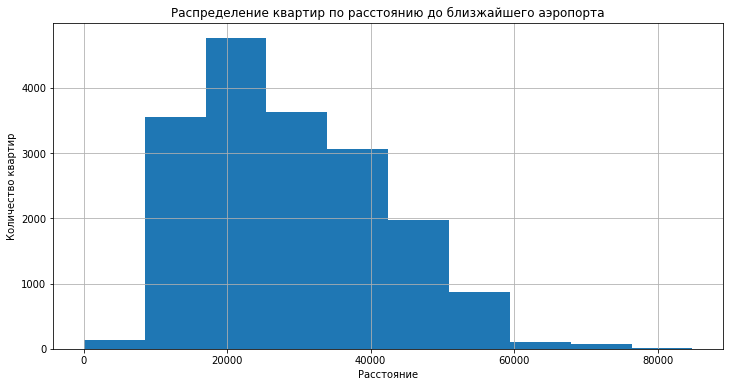

In [42]:
#исследую столбец airports_nearest
data['airports_nearest'].hist(figsize=(12,6))
plt.title('Распределение квартир по расстоянию до близжайшего аэропорта')
plt.xlabel('Расстояние')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца airports_nearest говорит о том, что большинство квартир находиться в диапазоне 10 000км - 50 000км от аэропорта

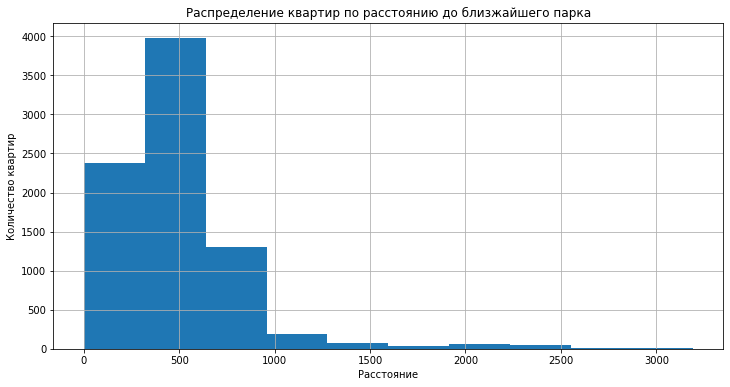

In [43]:
#исследую столбец parks_nearest
data['parks_nearest'].hist(figsize=(12,6))
plt.title('Распределение квартир по расстоянию до близжайшего парка')
plt.xlabel('Расстояние')
plt.ylabel('Количество квартир')
plt.show()

Анализ столбца parks_nearest говорит о том, что большинство квартир находиться не дальше чем на километр от близжайшего парка,
но в этой также можно выделить то, что там больше квартир которые находятся примерно в 500 метрах от близжайшего парка

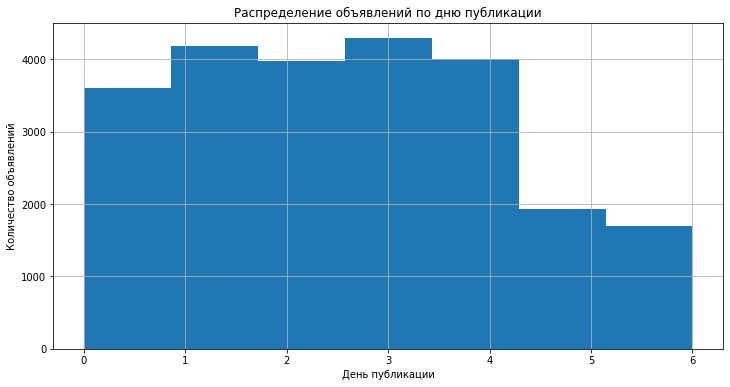

In [44]:
#исследую столбец publication_day
data['publication_day'].hist(figsize=(12,6), bins=7)
plt.title('Распределение объявлений по дню публикации')
plt.xlabel('День публикации')
plt.ylabel('Количество объявлений')
plt.show()

Анализ столбца publication_day говорит о том, что большинство объявлений было опубликовано в будние дни

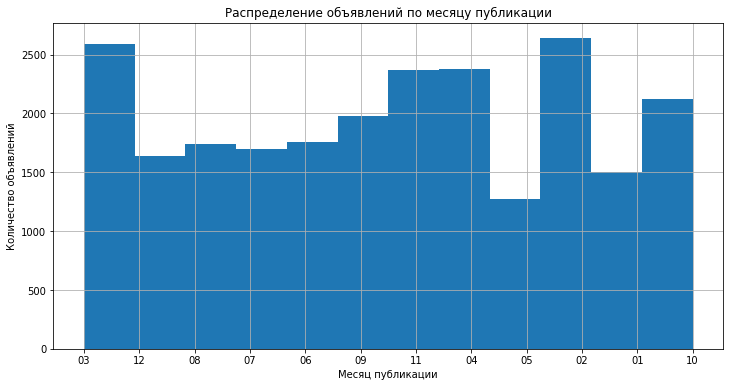

In [45]:
#исследую столбец publication_month
data['publication_month'].hist(figsize=(12,6), bins=12)
plt.title('Распределение объявлений по месяцу публикации')
plt.xlabel('Месяц публикации')
plt.ylabel('Количество объявлений')
plt.show()

Анализ столбца publication_month говорит о том, что большинство объявлений было опубликовано в марте и феврале, меньше всего объявлений было в мае

Промежуточный вывод
Большинство квартир выставленных на продажу во многом схожи
Общая площадь - не превышает 100 кв.м
Площадь кухни - не превышает 20 кв.м
Потолок - не превышает 5м
Цена - не превышает 10 млн
Не дальше 20км от центра города
Не дальше километра от близжайшего парка

## Изучение продаж квартир

Медиана равна -  95.0 
Среднее значение равно 169.36022616988058


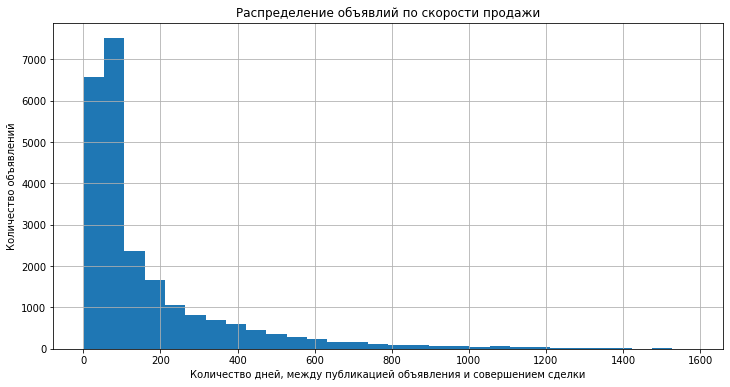

In [46]:
#изучение времени, которое уходит на продажу квартиры
data['days_exposition'].hist(figsize=(12,6), bins = 30)
print('Медиана равна - ',data['days_exposition'].median(),'\nСреднее значение равно',data['days_exposition'].mean())
plt.title('Распределение объявлий по скорости продажи')
plt.xlabel('Количество дней, между публикацией объявления и совершением сделки')
plt.ylabel('Количество объявлений')
plt.show()

Большинство квартир продаётся в течении 200 дней, если квартира не продаётся за это время, то вероятность продажи стремительно падает
Я буду считать так: быстрые продажи - быстрее 70 дней, долгие продажи - более 180 дней

            last_price
floor_type            
другой       4850000.0
первый       3900000.0
последний    4300000.0
                 last_price
publication_day            
0                 4650000.0
1                 4730000.0
2                 4700000.0
3                 4650000.0
4                 4585000.0
5                 4555000.0
6                 4550000.0
                   last_price
publication_month            
01                  4600000.0
02                  4650000.0
03                  4650000.0
04                  4800000.0
05                  4515000.0
06                  4400000.0
07                  4650000.0
08                  4570000.0
09                  4700000.0
10                  4570000.0
11                  4700000.0
12                  4700000.0
                  last_price
publication_year            
2014               7700000.0
2015               5350000.0
2016               4550000.0
2017               4500000.0
2018               4550000.0
2019      

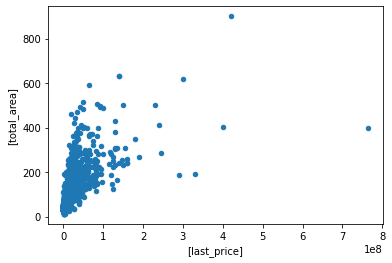

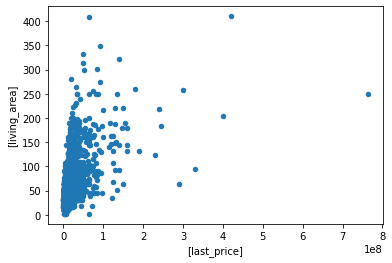

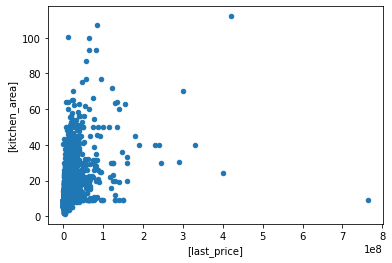

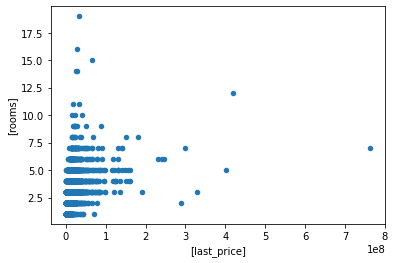

In [47]:
#поиск столбца, который имеет максимальное влияние на цену
data.plot.scatter(x = ['last_price'], y=['total_area'])
data.plot.scatter(x = ['last_price'], y=['living_area'])
data.plot.scatter(x = ['last_price'], y=['kitchen_area'])
data.plot.scatter(x = ['last_price'], y=['rooms'])
floor_stat = pd.pivot_table(data, values='last_price', index = 'floor_type', aggfunc='median')
print(floor_stat)
day_stat = pd.pivot_table(data, values='last_price', index = 'publication_day', aggfunc='median')
print(day_stat)
month_stat = pd.pivot_table(data, values='last_price', index = 'publication_month', aggfunc='median')
print(month_stat)
year_stat = pd.pivot_table(data, values='last_price', index = 'publication_year', aggfunc='median')
print(year_stat)

Промежуточный вывод:Больше всего на стоимость квартиры влияет её площадь

### Поиск цены квадратного метра

In [48]:
locality_stat = pd.pivot_table(data, values='price_per_square', index='locality_clean_name', aggfunc='mean').sort_values(by='price_per_square', ascending=False)
print(locality_stat.head(10))

                     price_per_square
locality_clean_name                  
зеленогорск             115122.799198
санкт-петербург         114849.008794
репино                  104238.614786
пушкин                  103125.819291
сестрорецк              101757.616875
лисий нос               100660.814239
мистолово                98549.976709
левашово                 96997.690531
кудрово                  95324.930544
неизвестно               94309.994932


Поиск влияния расстояния от центра города на цену

<AxesSubplot:xlabel='last_price', ylabel='cityCenters_nearest'>

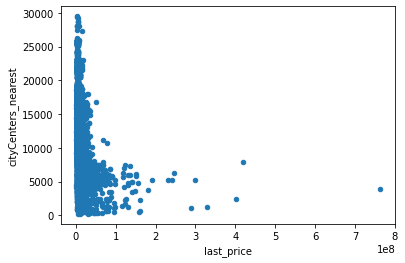

In [49]:
#создаю таблицу с питерскими квартирами и вычисляю "цену за километр"
import warnings

warnings.simplefilter('ignore')

spb_stat = data.query('locality_clean_name == "санкт-петербург"')
spb_stat['cost_per_km'] = spb_stat['last_price'] / spb_stat['cityCenters_nearest']
spb_stat.plot.scatter(x='last_price',y='cityCenters_nearest')

Чем ближе квартира к центру, тем она дороже, кто бы мог подумать

### Общий вывод

В данном проекте я занимался:

-Предобработкой данных :
заполнил нулевые значения, где это возможно.
Создал столбец с названиями населённых пунктов, где это возможно
Изменил тип данных некоторых столбцов, для возможности дальнейшего анализа

-Провёл анализ столбцов, и пришёл к выводу о том, что большая часть объявлений похожа друг на друга и имеет общие черты(см.вывод пункта 7)

-Провёл анализ продаж и ценообразования
Оказалось, что сильнее всего на цену квартиры влияет площадь и близость к центру города